In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import chess
import chess.engine
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from utils import Pgn_to_Dataframe,parse_time_control,compute_acpl_per_player,encode_chess_result,compute_blunders_and_best
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import make_pipeline


#### **Converting the PGN file into panda data frame**

In [148]:
path=r'd:\Chess_Eda\Chess_ml\games.pgn'
Pgn_to_Dataframe(path)


### **Reading the data set** 

In [149]:

path=r"d:\Chess_Eda\Chess_ml\games_dataset.csv"
df = pd.read_csv(path)
df



,white_rating,black_rating,result,opening,time_control,moves
0,1833,1823,0-1,Zukertort Opening: Tennison Gambit,120+0,e2e4 d7d5 g1f3 d5e4 f3e5 g8f6 d2d4 e4d3 f1d3 e...
1,1600,1658,1-0,Polish Opening: Czech Defense,240+2,b2b4 e7e5 c1b2 d7d6 c2c3 c8f5 d2d3 g8f6 e2e4 f...
2,1754,1790,1-0,Scandinavian Defense: Main Line,60+0,e2e4 d7d5 e4d5 d8d5 b1c3 d5a5 g1f3 g8f6 d2d4 c...
3,1601,1650,1-0,Russian Game: Three Knights Game,300+0,e2e4 e7e5 g1f3 g8f6 b1c3 d7d6 f1c4 c8e6 d1e2 b...
4,1657,1545,1-0,Semi-Slav Defense: Accelerated Move Order,60+0,d2d4 e7e6 c2c4 c7c6 b1c3 d7d5 c4d5 c6d5 e2e4 b...
...,...,...,...,...,...,...
1995,1553,1750,0-1,St. George Defense,600+10,e2e4 a7a6 b1c3 b8c6 g1f3 h7h6 f1c4 e7e6 d2d4 b...
1996,1796,1567,1/2-1/2,Ponziani Opening,300+0,e2e4 e7e5 g1f3 b8c6 c2c3 d7d6 d2d4 c8g4 c1e3 f...
1997,1259,1492,1-0,French Defense: Knight Variation,480+8,e2e4 e7e6 g1f3 f8c5 b1c3 c7c6 d2d4 c5b4 c1d2 d...
1998,2263,2031,1-0,"Caro-Kann Defense: Panov Attack, Fianchetto De...",60+0,e2e4 c7c6 d2d4 d7d5 e4d5 c6d5 c2c4 g8f6 b1c3 g...


## Data Cleaning: Time Control Feature
The **`time_control`** column describes the time format of each chess game.  
Some rows, however, contain **invalid or missing values**, such as:
- `"-"` → representing null/unknown data  
- `"0+X"` → representing games with **0 main time**, which is not a valid time control  

These need to be removed to ensure data quality.




In [150]:
for i in df.time_control:  # This drops rows that have value of 0 because there is no time control of 0 and also drops '-' which is null data
    if i=='-':
        df.drop(df[df.time_control == i].index, inplace=True)
    else:
        parts=i.split('+')
        main=int(parts[0])
        if main==0:
            df.drop(df[df.time_control == i].index, inplace=True)
    



## Feature Engineering: Number of Moves & Game Category

To enrich the dataset with additional insights, we created two new features:
1. **`num_moves`** → Total number of moves played in each game.  
2. **`game_category`** → Categorization of games based on their time control.  




In [151]:
df['num_moves'] = df['moves'].apply(lambda x: len(x.split()) //2 +1) # adding the game length column
df['game_category'] = df['time_control'].apply(parse_time_control)  # adding the game category column

## Feature Engineering: Average Centipawn Loss (ACPL)

To enhance the dataset, we engineered two new features:
- **White_ACPL**
- **Black_ACPL**

#### What is ACPL?
**Average Centipawn Loss (ACPL)** is a chess metric that measures the average loss in position (in centipawns) per move, compared to the best possible move suggested by a chess engine (Stockfish in this case).  
- A **lower ACPL** indicates stronger play (closer to engine-perfect moves).  
- A **higher ACPL** indicates more mistakes or inaccuracies.

#### How We Computed It
1. Used the **Stockfish engine** locally which is used in the function `compute_acpl_per_player()`
2. For each game in the dataset (`df['moves']`), the function `compute_acpl_per_player()` was applied.  
- This function analyzes the move sequence and calculates the **ACPL separately for White and Black**.
3. The results were stored in two new lists:
- `white_acpl_list`
- `black_acpl_list`
4. These lists were then added as new columns to the DataFrame:
```python
df['white_ACPL'] = white_acpl_list
df['Black_ACPL'] = black_acpl_list5 

Finally, the enhanced dataset was exported as:games_dataset_with_acpl.csv



In [152]:
stockfish_path = r"c:\Users\PCCV\Downloads\stockfish-windows-x86-64-avx2\stockfish\stockfish-windows-x86-64-avx2.exe"
# white_acpl_list = []
# black_acpl_list = []
# # for moves_str in df['moves']:
# #     white_acpl, black_acpl = compute_acpl_per_player(moves_str, stockfish_path)
# #     white_acpl_list.append(white_acpl)
# #     black_acpl_list.append(black_acpl)

# df['white_ACPL'] = white_acpl_list
# df['Black_ACPL'] = black_acpl_list
# df.to_csv("games_dataset_with_acpl.csv", index=False)


## Feature Engineering: Blunders and Best Moves

To enhance the dataset, we engineered four new features:  
- **white_best** – Number of best moves played by White  
- **black_best** – Number of best moves played by Black  
- **white_blunders** – Number of blunders by White  
- **black_blunders** – Number of blunders by Black  

#### What Are These Metrics?
These metrics are calculated using the **Stockfish engine**:  
- **Best moves**: Moves that match the engine’s top choice.  
- **Blunders**: Moves that significantly worsen the position (according to a defined centipawn threshold).  
- Tracking these helps quantify the quality of play for both players in a game.

#### How We Computed It
1. Initialized the Stockfish engine using the UCI protocol.
2. For each game in the dataset (`df['moves']`), the function `compute_blunders_and_best()` was applied.  
   - This function analyzes each move and returns a tuple: `(white_best, black_best, white_blunders, black_blunders)`.
```python
Finally, the enhanced dataset was exported as:games_dataset_with_acpl.csv


In [153]:

# engine = chess.engine.SimpleEngine.popen_uci(stockfish_path)
# df[['white_best', 'black_best', 'white_blunders', 'black_blunders']] = (
#     df['moves'].apply(lambda x: pd.Series(compute_blunders_and_best(x, engine)))
# )
# engine.quit()
# df.to_csv("Dataset_final")

## Reading the Dataset with ACPL , Blunders and best moves

After computing the **Average Centipawn Loss (ACPL)**  and **Blunders and Best Moves** for both White and Black players,  
loading the new dataset to be used in the machine learning model




In [154]:
path=r"d:\Chess_Eda\Chess_ml\Dataset_final.csv"
df=pd.read_csv(path)  # reading the csv file with acpl values
df.drop(columns=['Unnamed: 0'],inplace=True) #  removing Unnamed: 0' which was added by mistake in the function of blunder and best moves 

In [155]:
# df[['material_sacrifice','endgame']] = (
#     df['moves'].apply(analyze_material_and_endgame)
# )

### One-Hot Encoding the `game_category` Column

The following steps were performed to encode the categorical column `game_category` and add it back to the dataset:



In [156]:
encoder = OneHotEncoder(sparse_output=False)
encoded_array = encoder.fit_transform(df[['game_category']])
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(['game_category']))
df = df.join(encoded_df)
df.drop(columns='game_category',inplace=True)

## Converting Chess Results into ML-Friendly Columns

The `result` column contains strings such as `"1-0"`, `"0-1"`, or `"1/2-1/2"`.  
We will convert these into two numeric columns:

- **White_result** → `1` if White wins, `0` otherwise  
- **Black_result** → `1` if Black wins, `0` otherwise  

This transformation makes the dataset easier to use for machine learning models.


In [157]:
ml_dataset=df
white_result = []
black_result= []
for result in df['result']:
    white_acpl, black_acpl = encode_chess_result(result)
    white_result .append(white_acpl)
    black_result.append(black_acpl)
ml_dataset['White_result'] = white_result
ml_dataset['Black_result'] = black_result
ml_dataset.drop(columns='result',inplace=True)
ml_dataset

,white_rating,black_rating,opening,time_control,moves,num_moves,white_best,black_best,white_blunders,black_blunders,white_ACPL,Black_ACPL,game_category_blitz,game_category_bullet,game_category_classical,game_category_rapid,White_result,Black_result
0,1833,1823,Zukertort Opening: Tennison Gambit,120+0,e2e4 d7d5 g1f3 d5e4 f3e5 g8f6 d2d4 e4d3 f1d3 e...,33,15,22,1,2,36.906250,33.125000,0.0,1.0,0.0,0.0,0.0,1.0
1,1600,1658,Polish Opening: Czech Defense,240+2,b2b4 e7e5 c1b2 d7d6 c2c3 c8f5 d2d3 g8f6 e2e4 f...,67,21,20,5,7,53.865672,60.727273,1.0,0.0,0.0,0.0,1.0,0.0
2,1754,1790,Scandinavian Defense: Main Line,60+0,e2e4 d7d5 e4d5 d8d5 b1c3 d5a5 g1f3 g8f6 d2d4 c...,39,19,16,4,6,55.743590,74.763158,0.0,1.0,0.0,0.0,1.0,0.0
3,1601,1650,Russian Game: Three Knights Game,300+0,e2e4 e7e5 g1f3 g8f6 b1c3 d7d6 f1c4 c8e6 d1e2 b...,26,11,4,1,2,47.923077,53.840000,1.0,0.0,0.0,0.0,1.0,0.0
4,1657,1545,Semi-Slav Defense: Accelerated Move Order,60+0,d2d4 e7e6 c2c4 c7c6 b1c3 d7d5 c4d5 c6d5 e2e4 b...,29,9,8,5,5,80.793103,83.892857,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1886,1553,1750,St. George Defense,600+10,e2e4 a7a6 b1c3 b8c6 g1f3 h7h6 f1c4 e7e6 d2d4 b...,44,14,18,3,2,65.232558,57.883721,0.0,0.0,0.0,1.0,0.0,1.0
1887,1796,1567,Ponziani Opening,300+0,e2e4 e7e5 g1f3 b8c6 c2c3 d7d6 d2d4 c8g4 c1e3 f...,43,15,12,3,3,44.534884,45.976190,1.0,0.0,0.0,0.0,0.5,0.5
1888,1259,1492,French Defense: Knight Variation,480+8,e2e4 e7e6 g1f3 f8c5 b1c3 c7c6 d2d4 c5b4 c1d2 d...,26,12,6,0,2,36.115385,60.560000,1.0,0.0,0.0,0.0,1.0,0.0
1889,2263,2031,"Caro-Kann Defense: Panov Attack, Fianchetto De...",60+0,e2e4 c7c6 d2d4 d7d5 e4d5 c6d5 c2c4 g8f6 b1c3 g...,34,20,13,1,1,36.882353,39.666667,0.0,1.0,0.0,0.0,1.0,0.0


## Creating Performance vs Rating Ratio

We introduce a new feature called **`performance_vs_rating_ratio`**

- **Black_ACPL** → Average Centipawn Loss (ACPL) of the Black player  
- **white_rating** → Elo rating of the White player  

This ratio helps compare a player's performance (mistakes made) relative to the opponent's rating strength.  


In [158]:
ml_dataset['performance_vs_rating_ratio']=ml_dataset['Black_ACPL']/ml_dataset['white_rating']


## Preparing Features (X) and Target (Y)

To train our machine learning model, we need to separate:

- **Features (X):** The input variables the model will learn from  
- **Target (Y):** The output variable we want to predict  

### Features (X)
We include a mix of player ratings, game categories, move quality, results, and performance ratios:

- `white_rating` → Elo rating of White  
- `game_category_blitz`, `game_category_bullet`, `game_category_classical`, `game_category_rapid` → One-hot encoded game type  
- `white_best`, `black_best` → Best moves played by each side  
- `Black_result` → Encoded match result for Black  
- `white_ACPL` → White’s Average Centipawn Loss  
- `performance_vs_rating_ratio` → Black’s ACPL relative to White’s rating  

### Target (Y)
- `black_rating` → Elo rating of Black (the value we want to predict)


In [159]:
X=final_dataset[['white_rating','game_category_blitz','game_category_bullet','game_category_classical','game_category_rapid','white_best','black_best','Black_result','white_ACPL','performance_vs_rating_ratio']]			
Y=final_dataset[['black_rating']]

## Polynomial Regression Model Training

We will build a regression model to predict **Black's rating** from the selected features.

### Steps:
1. **Train-Test Split**  
   - Split the dataset into:
     - `X_train`, `Y_train` (75%) → for training the model  
     - `X_test`, `Y_test` (25%) → for testing the model  
   - Use `random_state=25` for reproducibility.  

2. **Polynomial Feature Expansion**  
   - Apply `PolynomialFeatures(degree=2)` to capture non-linear relationships between features.  
   - Transform `X_train` and `X_test` into polynomial features.  

3. **Model Training**  
   - Use `LinearRegression()` on the polynomial-transformed data.  
   - Fit the model with `X_train_poly` and `Y_train`.  



In [160]:

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.25,random_state=25)

<!-- ## **Polynomial Regression** -->

In [ ]:

poly = PolynomialFeatures(degree=2) 
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
model = LinearRegression()
model.fit(X_train_poly,Y_train)
X_poly = poly.fit_transform(X)
Y_pred_full = model.predict(X_poly) # predicating the whole Y for visualization later


In [162]:

Y_train_pred=model.predict(X_train_poly)
Y_test_pred=model.predict(X_test_poly)  

## Model Evaluation

After training the polynomial regression model, we evaluate its performance using two approaches:

### 1. R² Score on Train/Test Split
- `r_train`: Coefficient of determination (R²) on the training set  
- `r_test`: R² score on the test set  

This shows how well the model fits the training data and how well it generalizes to unseen data.

### 2. Cross-Validation (10-Fold)
- Use **K-Fold Cross-Validation** with 10 splits to get a more reliable estimate of model performance.  
- `cross_val_score` computes R² for each fold.  
- The **average R² score** gives an overall measure of model quality.  

This ensures that the model’s performance is not dependent on just one train-test split.


In [163]:
r_train=r2_score(Y_train,Y_train_pred)
r_test=r2_score(Y_test,Y_test_pred)

In [164]:

r_train

0.6532854762433861

In [165]:
r_test

0.6355366738806845

In [ ]:

degree = 2
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
kf = KFold(n_splits=10, shuffle=True, random_state=2)
r2_scores = cross_val_score(model, X, Y, cv=kf, scoring="r2")

print("R² scores for each fold:", r2_scores)
print("Average R² score:", np.mean(r2_scores))

R² scores for each fold: [0.63328053 0.62752773 0.62412131 0.64334754 0.66189539 0.68036474
 0.61987227 0.5567209  0.61581061 0.62725627]
Average R² score: 0.6290197283871763


## **Visualization**



## Preparing Residuals

To analyze model performance, we compute the **residuals**, which represent the difference between the actual and predicted values
Steps:
1. **Flatten arrays** to ensure both `Y` (actual) and `Y_pred_full` (predicted) have the same shape.  
2. **Compute residuals** by subtracting predicted values from actual values.  

These residuals will then be used for visualizations (line plot, histogram) and statistical tests.


In [ ]:
y_actual = Y.values.flatten()
y_pred = Y_pred_full.flatten()
residuals = y_actual - y_pred

## Residual Line Plot – Interpretation

The plot above shows residuals (`Actual - Predicted`) across all samples:

- Residuals are spread roughly evenly **above and below zero**.  
- No strong upward or downward pattern is visible.  
- This suggests the model is **unbiased** (it does not systematically over- or under-predict).  
- The variance of residuals looks fairly consistent across the dataset, which is a good sign for model assumptions.  

 Conclusion: The model’s errors appear to be random noise, meaning the polynomial regression is capturing the underlying relationship reasonably well.


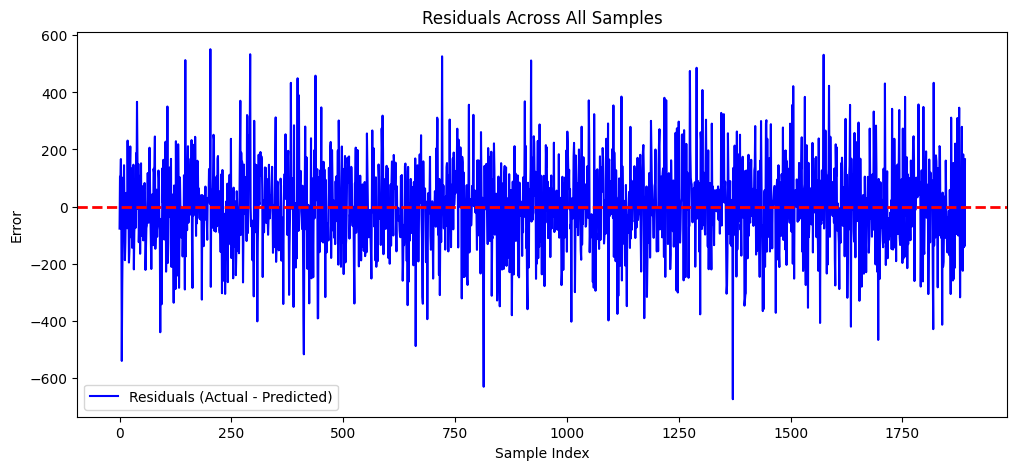

In [169]:


plt.figure(figsize=(12,5))
plt.plot(residuals, label="Residuals (Actual - Predicted)", color="blue")
plt.axhline(y=0, color="r", linestyle="--", linewidth=2)
plt.xlabel("Sample Index")
plt.ylabel("Error")
plt.title("Residuals Across All Samples")
plt.legend()
plt.show()



### Residual Distribution Analysis

The residual histogram shows that the errors are approximately **normally distributed around zero**.

- This indicates that the model is unbiased.  
- The variance of errors looks constant across predictions.  
- If we had seen skewness or a non-normal shape, it would suggest missing features or a poor fit.  

Overall, the model’s assumptions appear reasonable.


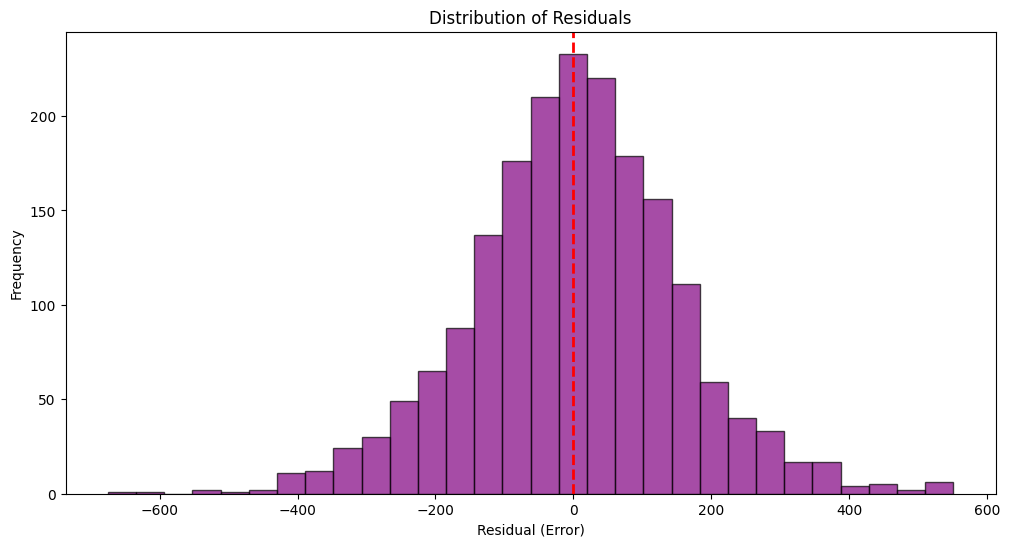

In [174]:

plt.figure(figsize=(12,6))
plt.hist(residuals, bins=30, color="purple", alpha=0.7, edgecolor="black")
plt.axvline(x=0, color="r", linestyle="--", linewidth=2)
plt.xlabel("Residual (Error)")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.show()

## Conclusion

- The model’s **R² score is relatively low**, which means it cannot explain all of the variance in player ratings.  
- This is expected due to the **nature of the domain (chess ratings)** and the presence of **noisy data** — many factors affect a player’s rating that are not captured in the dataset.  
- However, the **difference between actual and predicted ratings is usually within ±200 points**.  

 In chess terms, a 200-point range is **completely acceptable**, since:  
- Players often perform better or worse depending on style, preparation, and psychological factors.  
- A ±200 rating estimate still gives a **solid indication of the opponent’s strength level**.  

 **Overall:** While the model does not provide exact rating predictions, it produces estimates that are **practically useful** for understanding the opponent’s skill tier.
